In [ ]:
!pip install tensorflow==2.15.1
!pip install tensorflow-recommenders==0.7.3

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import tensorflow as tf
import tensorflow_recommenders as tfrs

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import urllib.request
from scipy.special import softmax
import csv

from tqdm import tqdm
tqdm.pandas()

In [ ]:
!wget https://raw.githubusercontent.com/imsreecharan/datasets_/refs/heads/master/amazon_reviews.csv


# Introduction

Cross Networks are designed to capture binary relations of the features. Classical Multi Layer Perceptron (MLP) can also do that but indirectly.

In traditional MLP:

$z^{(l)} = w^Tx^{(l-1)}$ (assuming bias term is included in $w$ and $x$)

$h^{(l)} = σ(z^{(l)})$ where $\sigma$ refers to the activation function.

As you can see the relationship between $x_i$ and $x_j$ is not *directly* modelled by MLP. Now let's look at the Cross Networks now:

$x^{(l)} = x_0 . (w^{(l)}x^{(l-1)}) + x^{(l-1)} + b^{(l)} + x^{(l-1)}$
 where $x_0$ refers to the input vector.

This formula directly models the cross relations. It took for me a while to grasp the concept so in case someone else out there also like me, let me give an example and explain how it works:

Say we want to model the relationship between age and income.

$x_0 = x^{(0)} = [age,income] = [25,1000]$ ; $b^{(1)} = [0,0]$

$w^{(1)} = [0.1,0.2]$ ; thus $w^{(1)}.x^{(0)} = 0.1 \times 25 + 0.2 \times 1000 = 202.5$

$x^{(1)} = [25,1000] \times 202.5 + [0,0] + [25,1000] = [5112.5,203500]$

As you can see $(w^{(l)}x^{(l-1)})$ directly models cross relations while calculating next layer.

The direct modelling allows a NN structure to work with less parameters and higher accuracy.

We can obtain a *Deep Cross Network* (DCN) by stacking dense and cross layers either in parallel or sequential. This combination can surpass the MLP performance especially if binary relations in the dataset is important. In this work, I will compare different MLP and DCN configurations on rating performance. Like in my previous [work](https://github.com/egonos/Data-Science-Projects/blob/main/Using%20ML%20for%20Commercial%20Purposes/Recommendation%20Algorithms/The%20Role%20of%20Text%20Features%20in%20Recommendation%20Systems.ipynb), I will again include sentiment scores of the review summaries in my models since they contribute to the rating predictions significantly.

# Models

## 1. User Model
UserId ----> StringLookup (equivalent to the OrdinalEncoder) ----> Embedding (1,16) => User Embedding ($u_v)$
(1,16)

ReviewSummary ----> TextVectorizer (split the words and encode them) ----> Embedding + GlobalAverage1d (1,16) => Summary Embedding ($u_z$)
(1,16)

Sentiment Scores ($u_t$) (1,3)

Concatenate($u_v$,$u_t$,$u_z$) => UserSentimentSummary Embedding ($u_m$) (1,35)


FFN($u_m$) (1,16) => UserSentimentSummary Vector ($u_r$) (1,16)




## 2. Product Model

ProductId ----> StringLookup ----> Embedding (1,16) => Product Embedding ($u_i$) (1,16)

## 3. Rank Model

Concatenate($u_r$, $u_i$) => Rank Input Vector ($u_z$) (1,32)

FFN Configuration: *config*

$FFN_{config}(u_z)$ => Rating Predictions

### 3.1. Ranking Model Objective:

min MSE(Rating Prediction, Rating)

# Results

All model perforances were similar. This may be caused because of the sentiment scores. These scores heavily impact the rating predictions making the binary relations unimportant.  

In [4]:
reviews = pd.read_csv('amazon_reviews.csv',index_col = 0).rename(columns = {'asin': 'product_id'})[["product_id","overall","reviewerID","summary"]]
reviews.head()

,product_id,overall,reviewerID,summary
0,0528881469,5.0,AO94DHGC771SJ,Gotta have GPS!
1,0528881469,1.0,AMO214LNFCEI4,Very Disappointed
2,0528881469,3.0,A3N7T0DY83Y4IG,1st impression
3,0528881469,2.0,A1H8PY3QHMQQA0,"Great grafics, POOR GPS"
4,0528881469,1.0,A24EV6RXELQZ63,"Major issues, only excuses for support"


In [5]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)


labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]


model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [6]:
def get_roberta_scores(row):
  encoded_text = tokenizer(row["summary"],return_tensors ="pt")
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  return scores

reviews[["negative","neutral","positive"]] = reviews.progress_apply(get_roberta_scores,axis = 1,result_type = "expand")

100%|██████████| 999/999 [01:42<00:00,  9.75it/s]


In [7]:
unique_product_id = np.unique(reviews["product_id"])
unique_reviewerID = np.unique(reviews["reviewerID"])

dataset = tf.data.Dataset.from_tensor_slices({
    "reviewerID": reviews["reviewerID"].values,
    "product_id": reviews["product_id"].values,
    "summary": reviews["summary"].values,
    "negative": reviews["negative"].values,
    "neutral": reviews["neutral"].values,
    "positive": reviews["positive"].values,
    "overall": reviews["overall"].values
})

candidate_dataset = tf.data.Dataset.from_tensor_slices({"product_id": unique_product_id})

shuffled = dataset.shuffle(len(dataset), seed=42, reshuffle_each_iteration=False)
train = shuffled.take(int(len(dataset) * 0.8)).batch(32)
test = shuffled.skip(int(len(dataset) * 0.8)).batch(32)

In [8]:
class ProductModel(tf.keras.Model):
  def __init__(self):
    super().__init__()

    self.product_model = tf.keras.Sequential([tf.keras.layers.StringLookup(vocabulary = unique_product_id),
                                              tf.keras.layers.Embedding(len(unique_product_id) + 1, 16)])

  def call(self,inputs):
    return self.product_model(inputs["product_id"])

In [9]:
class UserModel(tf.keras.Model):
  def __init__(self):
    super().__init__()

    self.user_model = tf.keras.Sequential([tf.keras.layers.StringLookup(vocabulary = unique_reviewerID),
                                           tf.keras.layers.Embedding(len(unique_reviewerID) + 1, 16)])

    self.text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = 10000)
    self.text_vectorizer.adapt(reviews["summary"].values)


    self.summary_model = tf.keras.Sequential([self.text_vectorizer,
                                              tf.keras.layers.Embedding(10000, 16,mask_zero = True),
                                              tf.keras.layers.GlobalAveragePooling1D()])

    self.dense = tf.keras.layers.Dense(16)

  def call(self, inputs):

    components = [self.user_model(inputs["reviewerID"]),
                  self.summary_model(inputs["summary"]),
                  tf.expand_dims(inputs["negative"], axis=1),
                  tf.expand_dims(inputs["neutral"], axis=1),
                  tf.expand_dims(inputs["positive"], axis=1)]
    return self.dense(tf.concat(components, axis=1))


In [10]:
class Rank(tfrs.Model):
  def __init__(self,use_cross_networks,hidden_units = None):
    super().__init__()
    self.user_model = UserModel()
    self.product_model = ProductModel()
    self.task = tfrs.tasks.Ranking(loss = tf.keras.losses.MeanSquaredError(),
                                  metrics = [tf.keras.metrics.RootMeanSquaredError()])

    self.rank_model = tf.keras.Sequential()

    if use_cross_networks:
      self.rank_model.add(tfrs.layers.dcn.Cross())

    if hidden_units:
      for hidden_unit in hidden_units:
        self.rank_model.add(tf.keras.layers.Dense(hidden_unit,activation = "relu"))

    self.rank_model.add(tf.keras.layers.Dense(1))

  def call(self,inputs):
    interaction_vector = self.user_model(inputs)
    product_embeddings = self.product_model(inputs)
    return self.rank_model(tf.concat([interaction_vector,product_embeddings],axis = 1))

  def compute_loss(self,inputs,training = False):
    rating_predictions = self(inputs)
    return self.task(labels = inputs["overall"],predictions = rating_predictions)

In [11]:
tf.random.set_seed(42)
USE_CROSS_NETWORKS = False
HIDDEN_UNITS = [32]

rank_model1 = Rank(use_cross_networks=USE_CROSS_NETWORKS,hidden_units=HIDDEN_UNITS)
rank_model1.compile(optimizer = tf.keras.optimizers.Adagrad(0.01))

model1_history = rank_model1.fit(train,epochs = 10,validation_data = test,verbose = 0)

In [12]:
tf.random.set_seed(42)
USE_CROSS_NETWORKS = False
HIDDEN_UNITS = [32,16]

rank_model2 = Rank(use_cross_networks=USE_CROSS_NETWORKS,hidden_units=HIDDEN_UNITS)
rank_model2.compile(optimizer = tf.keras.optimizers.Adagrad(0.01))

model2_history = rank_model2.fit(train,epochs = 10,validation_data = test,verbose = 0)

In [13]:
tf.random.set_seed(42)
USE_CROSS_NETWORKS = True
HIDDEN_UNITS = [32]

rank_model3 = Rank(use_cross_networks=USE_CROSS_NETWORKS,hidden_units=HIDDEN_UNITS)
rank_model3.compile(optimizer = tf.keras.optimizers.Adagrad(0.01))

model3_history = rank_model3.fit(train,epochs = 10,validation_data = test,verbose = 0)

In [14]:
tf.random.set_seed(42)
USE_CROSS_NETWORKS = True
HIDDEN_UNITS = None

rank_model4 = Rank(use_cross_networks=USE_CROSS_NETWORKS,hidden_units=HIDDEN_UNITS)
rank_model4.compile(optimizer = tf.keras.optimizers.Adagrad(0.01))

model4_history = rank_model4.fit(train,epochs = 10,validation_data = test,verbose = 0)

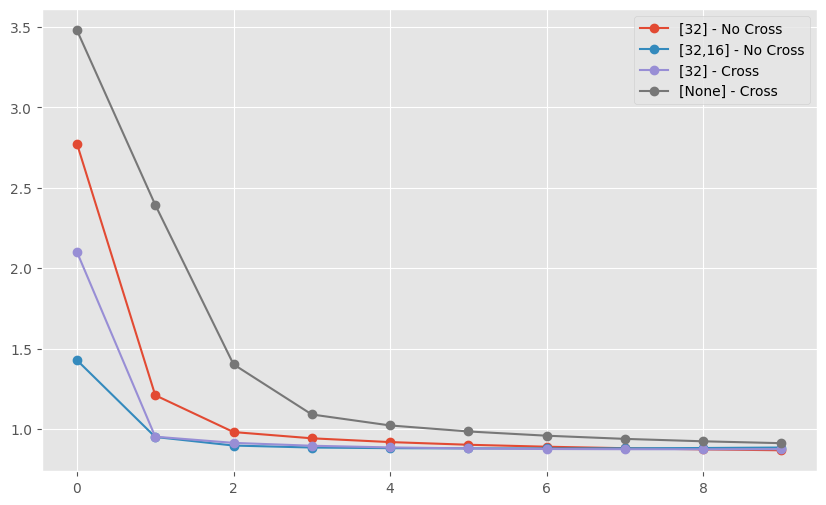

In [15]:
plt.figure(figsize = (10,6))
plt.plot(model1_history.history["val_root_mean_squared_error"],label = "[32] - No Cross",marker = "o")
plt.plot(model2_history.history["val_root_mean_squared_error"],label = "[32,16] - No Cross",marker = "o")
plt.plot(model3_history.history["val_root_mean_squared_error"],label = "[32] - Cross",marker = "o")
plt.plot(model4_history.history["val_root_mean_squared_error"],label = "[None] - Cross",marker = "o")
plt.legend()
plt.show()